Tenho uma carteira com 5 ações. Dado a distribuição dos retornos dessa carteira no último ano:
- qual o máx que eu posso perder nos próx 3 anos, com uma confiança de 95%?
- qual a probabilidade de eu obter lucro?

Resolução:
- vamos simular 10 mil cenários da carteira com 5 ações nos próx 3 anos e criar uma distribuição de retornos com os cenários. Para isso, vamos utilizar Monte Carlo.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from numpy import linalg as LA
import yfinance as yf

Pegando dados:

In [43]:
lista_acoes = ['WEGE3', 'PCAR3', 'LREN3', 'PETR4', 'VALE3']
lista_acoes = [acao +'.SA' for acao in lista_acoes]

data_final = dt.datetime.now()
data_inicial = data_final - dt.timedelta(days=300)

precos = yf.download(lista_acoes, data_inicial, data_final)['Adj Close']

precos

[*********************100%***********************]  5 of 5 completed


,LREN3.SA,PCAR3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,
2022-06-13,22.401089,18.620001,20.853727,75.914040,23.425089
2022-06-14,22.188206,17.969999,21.088840,75.765701,23.847958
2022-06-15,23.126823,18.350000,20.718361,75.719345,23.602104
2022-06-17,22.972002,17.889999,19.457304,71.769737,22.451502
2022-06-20,23.097799,16.719999,19.678167,69.998909,23.700447
...,...,...,...,...,...
2023-03-31,16.570000,14.730000,23.450001,80.290001,40.549999
2023-04-03,15.410000,14.670000,24.490000,80.309998,39.590000
2023-04-04,15.390000,14.620000,24.270000,78.040001,39.630001


Calculando retornos e pegando matriz de covariância

In [51]:
retornos = precos.pct_change().dropna()
matriz_covariancia = retornos.cov()
pesos_carteira = np.full(len(lista_acoes), 1/len(lista_acoes))
numero_acoes = len(lista_acoes)

matriz_covariancia

,LREN3.SA,PCAR3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
LREN3.SA,0.000830,0.000417,0.000166,-0.000009,0.000225
PCAR3.SA,0.000417,0.000965,0.000264,0.000058,0.000143
PETR4.SA,0.000166,0.000264,0.000724,0.000155,0.000104
VALE3.SA,-0.000009,0.000058,0.000155,0.000492,0.000108
WEGE3.SA,0.000225,0.000143,0.000104,0.000108,0.000399


retornos_sintericos = retorno_medio + Rpdf * L.
- Rpdf = matriz aleatória gerada por alguma função de densidade de probabilidade.
- L = matriz triangular inferior proveniente de uma decomposição de Cholesky, usando como base a matriz de covariância dos dados originais.

Premissas Monte Carlo

In [53]:
num_simulacoes = 10000
dias_projetados = 252 * 3
capital_inicial = 1000

Gerando retorno médio

In [54]:
retorno_medio = retornos.mean(axis = 0).to_numpy()
matriz_retorno_medio = retorno_medio * np.ones(shape = (dias_projetados, numero_acoes))

matriz_retorno_medio

array([[-0.00131584, -0.00081219,  0.00104825,  0.00029592,  0.00263699],
       [-0.00131584, -0.00081219,  0.00104825,  0.00029592,  0.00263699],
       [-0.00131584, -0.00081219,  0.00104825,  0.00029592,  0.00263699],
       ...,
       [-0.00131584, -0.00081219,  0.00104825,  0.00029592,  0.00263699],
       [-0.00131584, -0.00081219,  0.00104825,  0.00029592,  0.00263699],
       [-0.00131584, -0.00081219,  0.00104825,  0.00029592,  0.00263699]])

Gerando L

In [55]:
L = LA.cholesky(matriz_covariancia)
L

array([[ 0.02880388,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.01448853,  0.02747892,  0.        ,  0.        ,  0.        ],
       [ 0.00575056,  0.00656455,  0.02546218,  0.        ,  0.        ],
       [-0.00030535,  0.00228887,  0.00554707,  0.02135921,  0.        ],
       [ 0.00782319,  0.00107354,  0.00203699,  0.0045466 ,  0.01765041]])

Gerando simulações

In [59]:
retornos_carteira = np.zeros([dias_projetados, num_simulacoes]) #cada coluna é uma simulação
montante_final = np.zeros(num_simulacoes)

for i in range(num_simulacoes):
    Rpdf = np.random.normal(size = (dias_projetados, numero_acoes))
    retornos_sinteticos = matriz_retorno_medio + np.inner(Rpdf, L) #única coisa random é o Rpdf
    retornos_carteira[:, i] = np.cumprod(np.inner(pesos_carteira, retornos_sinteticos) + 1) * capital_inicial
    montante_final[i] = retornos_carteira[-1, i]

montante_final

array([1512.66012393, 1176.8530404 , 1081.35273731, ..., 1004.99596633,
        794.76855553, 1706.4421886 ])

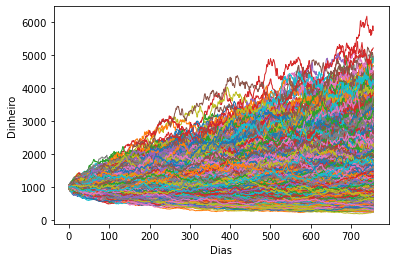

In [60]:
plt.plot(retornos_carteira, linewidth = 1)
plt.ylabel('Dinheiro')
plt.xlabel('Dias')
plt.show()

In [81]:
montante_99 = str(np.percentile(montante_final, 1))
montante_95 = str(np.percentile(montante_final, 5))
montante_mediano = str(np.percentile(montante_final, 50))
cenarios_com_lucro = str((len(montante_final[montante_final > 1000]) / len(montante_final)) * 100) + '%'

In [83]:
print(f'''Ao investir R$1000,000 na carteira {lista_acoes},
podemos esperar esses resultados para os próximos 3 anos, 
utilizando o método de Monte Carlo com 10 mil simulações:

Com 50% de probabilidade, o montante será maior que R${montante_mediano}.
Com 95% de probabilidade, o montante será maior que R${montante_95}.
Com 99% de probabilidade, o montante será maior que R${montante_99}.

Em {cenarios_com_lucro} dos cenários, foi possível obter lucro nos próximos 3 anos.''')

Ao investir R$1000,000 na carteira ['WEGE3.SA', 'PCAR3.SA', 'LREN3.SA', 'PETR4.SA', 'VALE3.SA'],
podemos esperar esses resultados para os próximos 3 anos, 
utilizando o método de Monte Carlo com 10 mil simulações:

Com 50% de probabilidade, o montante será maior que R$1192.4148244399616.
Com 95% de probabilidade, o montante será maior que R$567.4290117718388.
Com 99% de probabilidade, o montante será maior que R$418.2861099253157.

Em 65.63% dos cenários, foi possível obter lucro nos próximos 3 anos.


Apartir dessas métricas, é possível calcular coisas como o VAR da carteira para diferentes intervalos de confiança e medir se o risco que se está correndo é compatível com o que se aguenta perder. No caso dessa carteira, uma queda de quase 43% está dentro dso 95% dos cenários mais possíveis de acontecer nos próximos 3 anos.

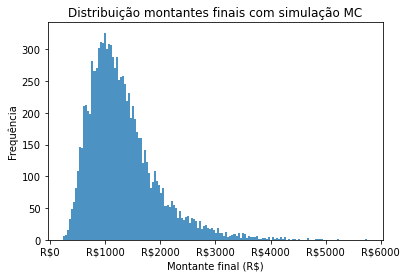

In [85]:
config = dict(histtype = 'stepfilled', alpha = 0.8, density = False, bins = 150)
fig, ax = plt.subplots()
ax.hist(montante_final, **config)
ax.xaxis.set_major_formatter('R${x:.0f}')
plt.title('Distribuição montantes finais com simulação MC')
plt.xlabel('Montante final (R$)')
plt.ylabel('Frequência')
plt.show()